In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

from sklearn.cluster import KMeans
import datetime
from scipy.cluster.hierarchy import dendrogram, linkage

from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs

import skfda
from skfda.ml.clustering import FuzzyCMeans

Cluster Analysis: To better understand what typical charging sessions look like, carry out a cluster
analysis to provide management with a succinct report of archetypical charging events. Think of an
appropriate trade-off between explainability and information content and try to come up with names
for these clusters. What is the value of identifying different types of charging sessions?

Data Preparations for the Clustering

In [13]:
input_data = pd.read_csv("../charging_cleaned.csv")

# determining the total amount of seconds spent on the charging station
time_in = input_data["connectionTime"]
time_out = input_data["disconnectTime"]

# time on charging station while not charging
time_w = input_data["doneChargingTime"]
time_w = pd.to_datetime(time_w)

time_in = pd.to_datetime(time_in)
time_out = pd.to_datetime(time_out)

time_all = time_out - time_in
time_sec = np.zeros(time_all.size)

for i in range(time_all.size):
   time_sec[i] = int(time_all[i].total_seconds())


KWh = input_data["kWhDelivered"]

time_charging = time_w - time_in

time_charging_sec = np.zeros(time_charging.size)

for i in range(time_charging.size):
   time_charging_sec[i] = int(time_charging[i].total_seconds())

site_Id = input_data["siteID"]



In [14]:
# Total time in minutes rounded down to minutes
year_in = time_in.dt.year
year_out = time_out.dt.year
year_w = time_w.dt.year

# preparing the months just using the connectiontime
month_in = time_in.dt.month 
month_out = time_out.dt.month 
month_w = time_w.dt.month 

# preparing the days just using the connectiontime
days_in = time_in.dt.day 
day_year_in = time_in.dt.day_of_year

days_our = time_out.dt.day 
day_year_out = time_out.dt.day_of_year

days_w = time_w.dt.day 
day_year_w = time_w.dt.day_of_year

# minute of the hour
minute_in = time_in.dt.minute
minute_out = time_out.dt.minute
minute_w = time_w.dt.minute

# time of the day
time_of_day_in = time_in.dt.hour 
time_of_day_out = time_out.dt.hour 
time_of_day_w = time_w.dt.hour 

time_in_min =  time_of_day_in + minute_in / 60 

time_out_min =  time_of_day_out  + minute_out / 60 

time_w_min =  time_of_day_w  + minute_w / 60 

In [15]:
# determining the total amount of seconds spent on the charging station
time_all_user = input_data["userInputs_minutesAvailable"]

KWh_user = input_data["userInputs_kWhRequested"]

Wh_per_mile_user = input_data["userInputs_WhPerMile"]

miles_req = input_data["userInputs_milesRequested"]

mod_at = input_data["userInputs_modifiedAt"]

pay_req = input_data["userInputs_paymentRequired"]

req_dep = input_data["userInputs_requestedDeparture"]

K-Means Clustering

In [16]:
data_clustering = pd.DataFrame()
data_clustering["connectionTime"] = time_in_min
data_clustering["diconnectionTime"] = time_out_min
data_clustering["doneChargingTime"] = time_w_min
data_clustering["kWhDelivered"] = KWh
data_clustering["minutesAvailable"] = time_all_user
data_clustering["milesRequested"] = miles_req
data_clustering["kWhRequested"] = KWh_user

In [17]:
X = data_clustering

scaler = StandardScaler()
scaler.fit(data_clustering)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=data_clustering.columns, index=data_clustering.index)
X_scaled_df.head()

data_clustering_s = X_scaled_df

print(X_scaled)

[[-0.36191103  0.8189436   0.31846318 ...  0.66477004  0.44100561
  -0.02355155]
 [-0.27766675  1.17235763  0.66792674 ...  1.41380302  3.18238807
   2.46582661]
 [-0.21749227 -1.07958976  0.2012778  ... -1.62205035 -1.02106503
  -0.9639833 ]
 ...
 [ 0.70919476  1.18260152  0.97553837 ... -1.2929298  -0.8383062
  -0.74270524]
 [ 0.75432562 -1.08812633  0.80813068 ...  1.00523957  2.26859392
   1.35943632]
 [ 0.76034307  1.1074797   0.73698241 ...  1.14142739 -0.38140912
  -0.56983176]]


In [18]:
# k_max = 50

# clusters = []
# losses = []

# for k in range(k_max):
#     model = KMeans(n_clusters=k+1, n_init='auto')
#     model.fit(X_scaled)
#     clusters.append(k+1)
#     losses.append(model.inertia_)


# plt.plot(clusters, losses)
# plt.ylabel("Loss")
# plt.xlabel("Number of clusters")
# plt.show()

In [19]:
# plt.plot(clusters, losses)
# plt.ylabel("Loss")
# plt.xlabel("Number of Clusters")
# plt.xlim([0,10])

In [20]:
# two_means = KMeans(n_clusters=4, n_init='auto')
# two_means.fit(X_scaled)

# two_means.predict(X_scaled)

In [21]:
# numbers = ["zero", "one", "two", "three", "four"] 

# data_clustering_s["four"] = two_means.predict(X_scaled)
# data_clustering_s["four"] = data_clustering_s["four"].apply(lambda x: numbers[x])
# sns.pairplot(data=data_clustering_s, hue="four")

In [22]:
# plt.figure(figsize=(15, 10))  
# plt.title("Hierarchical Clustering")  
# plt.xlabel('Index')
# plt.ylabel('Euclidean Distance')
# dendrogram(linkage(X_scaled, method='ward', ))

<Axes: >

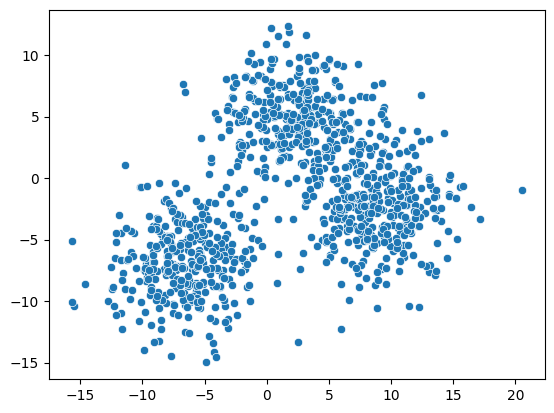

In [23]:
N = 1000
C = 3

X, y_true = make_blobs(n_samples=N, centers=C, cluster_std=3, random_state=42)
X = X[:, ::-1]

sns.scatterplot(x=X[:,0], y=X[:,1])

In [24]:
X_f = skfda.FDataGrid(X)

fuzzy_model = FuzzyCMeans(n_clusters=3, fuzzifier = 2)
cluster = fuzzy_model.fit_predict(X_f)

U = fuzzy_model.membership_degree_
U_max = np.max(U, axis=1)

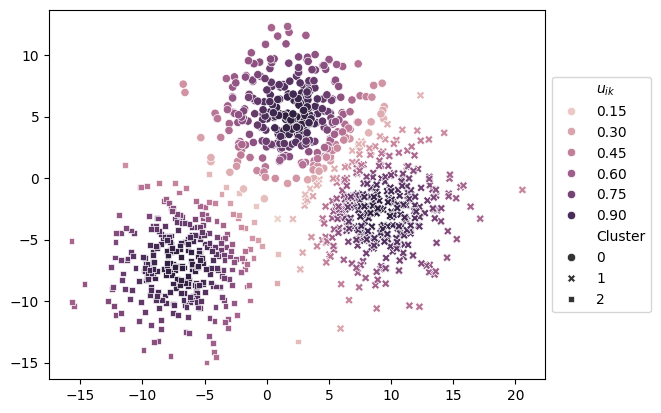

In [25]:
ax = sns.scatterplot(
    x=X[:,0], 
    y=X[:,1], 
    style=pd.Series(cluster, name='Cluster'), 
    hue=pd.Series(U_max**2, name='$u_{ik}$')
)
ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))

The same clustering strategies as above with sampled data instead of the full data

In [26]:
data_sampled = data_clustering.sample(n=3000, random_state=42)

In [27]:
  
X_sampled = data_sampled

scaler = StandardScaler()
scaler.fit(data_clustering)
X_scaled_sam = scaler.transform(X_sampled)
X_scaled_sam_df = pd.DataFrame(X_scaled_sam, columns=data_sampled.columns, index=data_sampled.index)
X_scaled_sam_df.head()

data_clustering_sam = X_scaled_sam_df

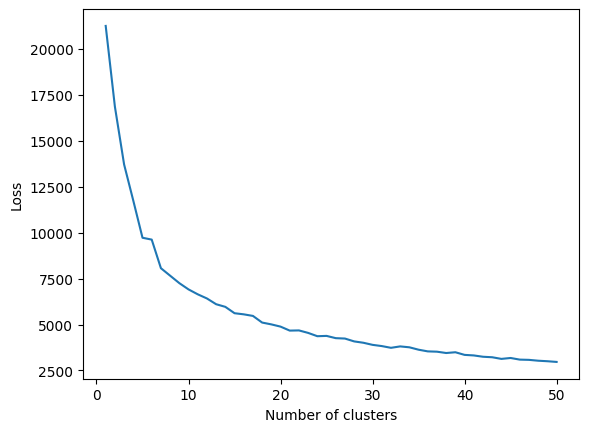

In [28]:
# Kmeans of all of the values

k_max = 50

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters=k+1, n_init='auto')
    model.fit(X_scaled_sam)
    clusters.append(k+1)
    losses.append(model.inertia_)


plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

(0.0, 10.0)

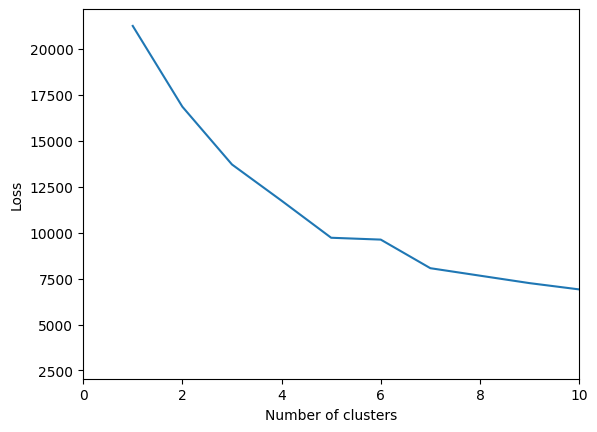

In [29]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,10])

In [30]:
two_means_sam = KMeans(n_clusters=4, n_init='auto')
two_means_sam.fit(X_scaled_sam)

two_means_sam.predict(X_scaled_sam)

array([2, 0, 1, ..., 0, 2, 0])

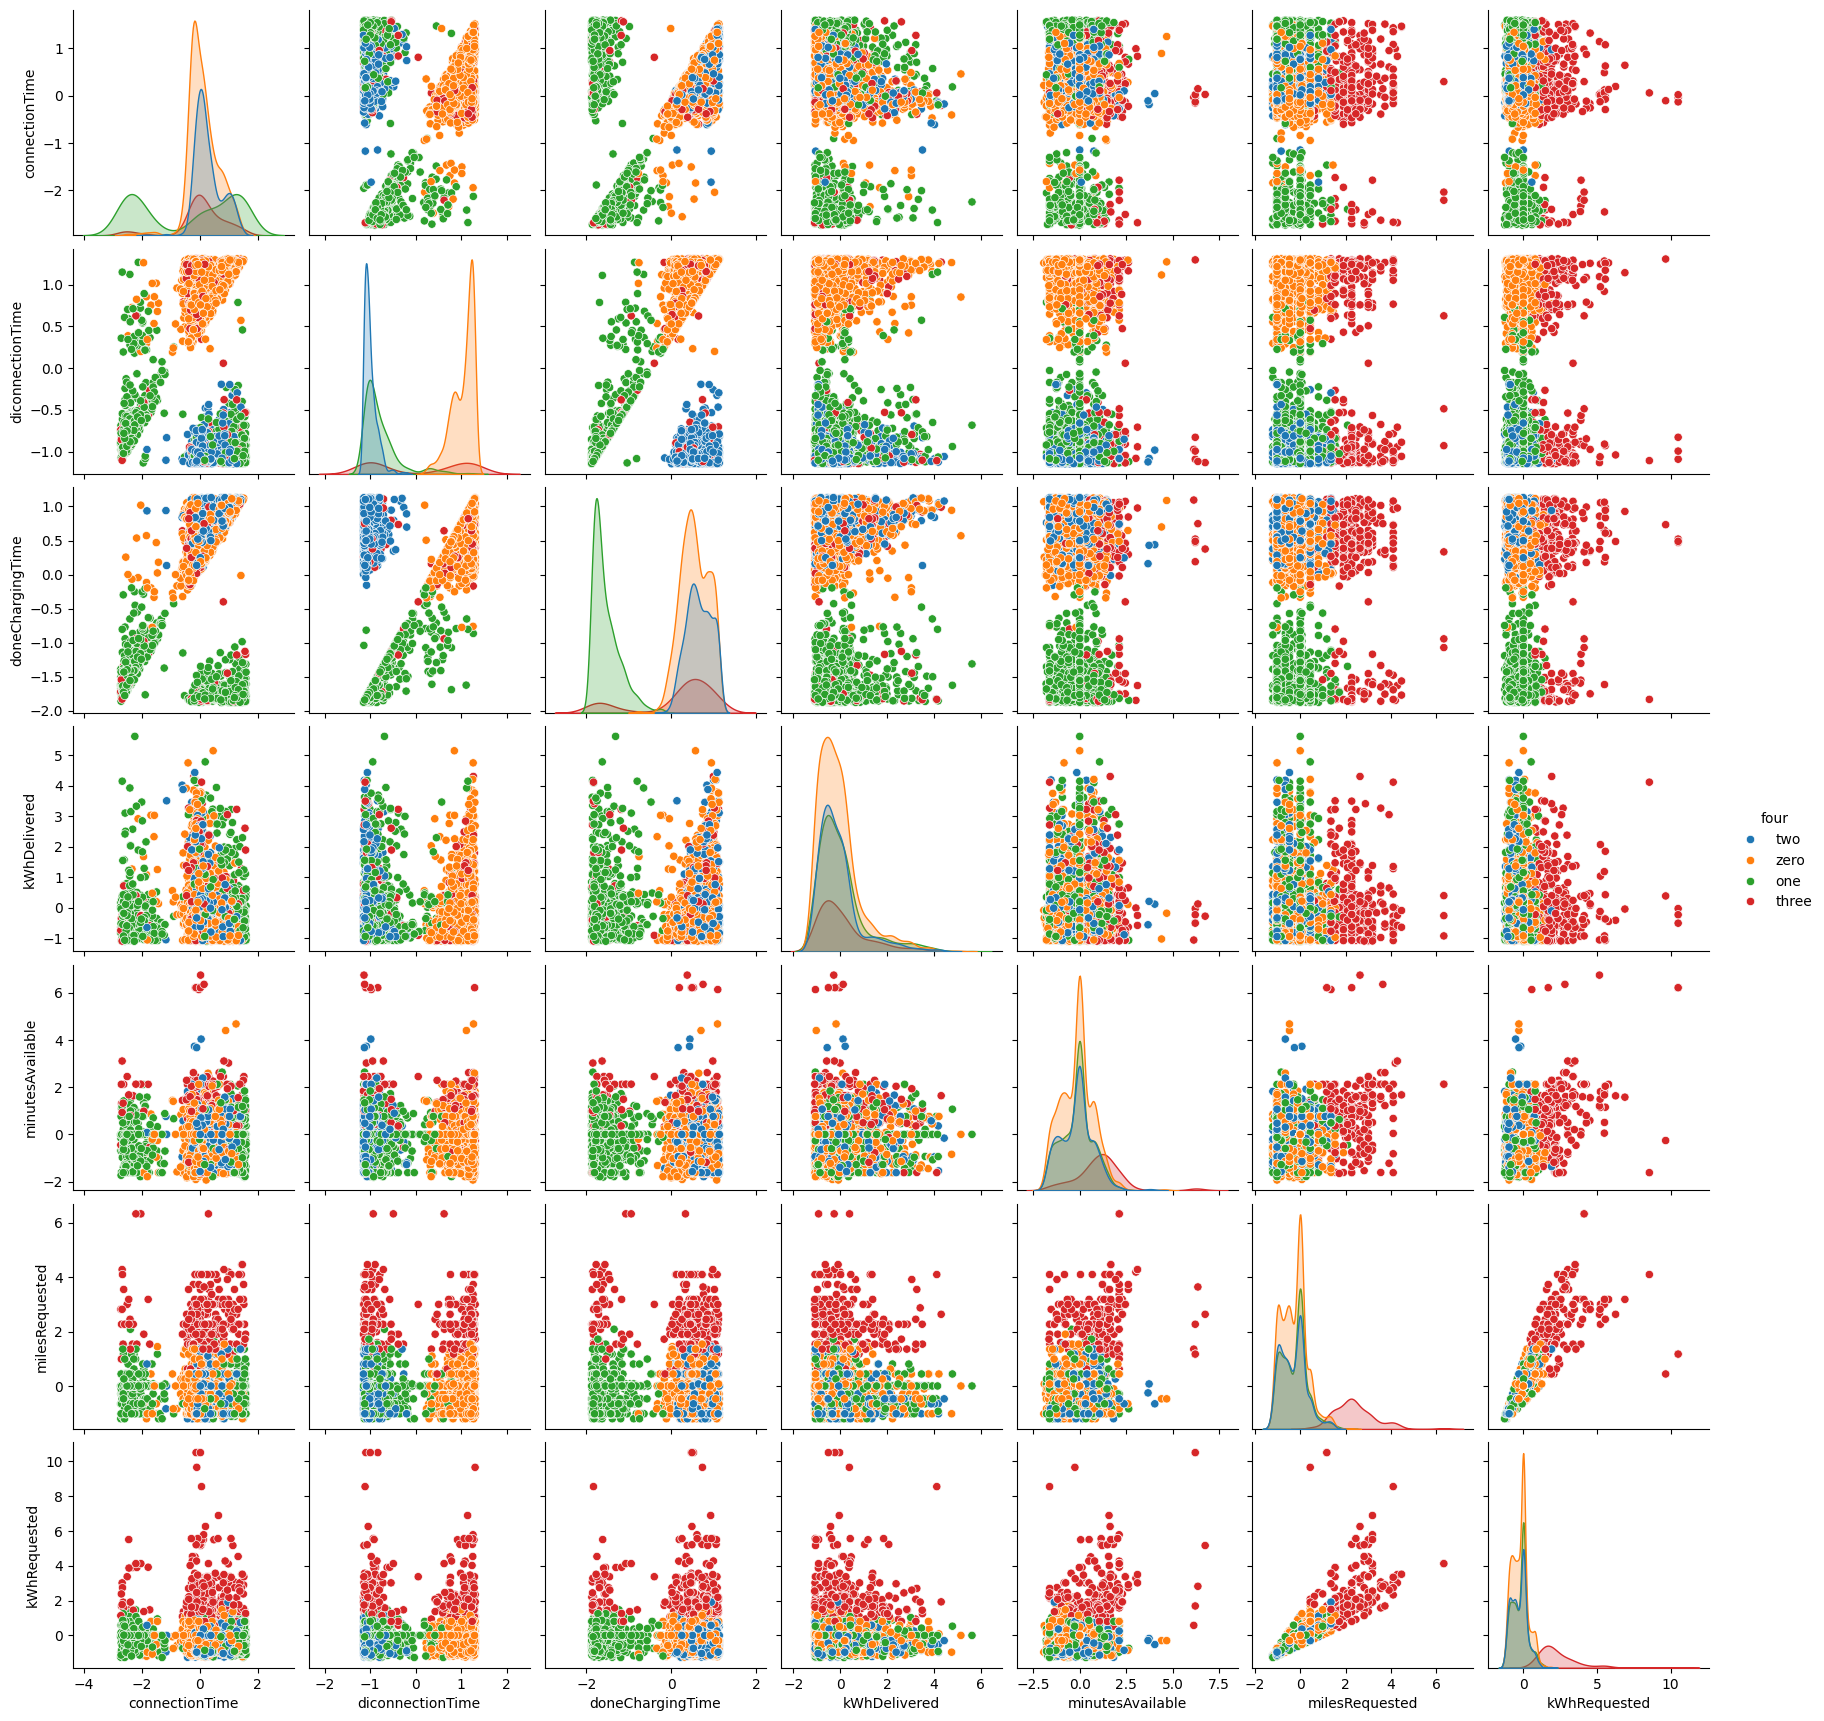

In [31]:
numbers = ["zero", "one", "two", "three", "four"] 

data_clustering_sam["four"] = two_means_sam.predict(X_scaled_sam)
data_clustering_sam["four"] = data_clustering_sam["four"].apply(lambda x: numbers[x])
pair_plot = sns.pairplot(data=data_clustering_sam, hue="four")

In [32]:

centroids = two_means_sam.cluster_centers_
print(two_means_sam.labels_.size)

print(X_scaled_sam.shape)
print(data_sampled.size)

data_sampled["label"] = two_means_sam.labels_


3000
(3000, 7)
21000


In [33]:
groups = pd.DataFrame()
groups["connectMean"] = data_sampled.groupby("label")["connectionTime"].mean()
groups["disconnectMean"] = data_sampled.groupby("label")["diconnectionTime"].mean()
groups["doneChargingMean"] = data_sampled.groupby("label")["doneChargingTime"].mean()
groups["kWhdeliveredMean"] = data_sampled.groupby("label")["kWhDelivered"].mean()
groups["minuteAvailableMean"] = data_sampled.groupby("label")["minutesAvailable"].mean()
groups["milesRequestedMean"] = data_sampled.groupby("label")["milesRequested"].mean()
groups["kWhRequestedMean"] = data_sampled.groupby("label")["kWhRequested"].mean()

groups["connectMax"] = data_sampled.groupby("label")["connectionTime"].max()
groups["disconnectMax"] = data_sampled.groupby("label")["diconnectionTime"].max()
groups["doneChargingMax"] = data_sampled.groupby("label")["doneChargingTime"].max()
groups["kWhdeliveredMax"] = data_sampled.groupby("label")["kWhDelivered"].max()
groups["minuteAvailableMax"] = data_sampled.groupby("label")["minutesAvailable"].max()
groups["milesRequestedMax"] = data_sampled.groupby("label")["milesRequested"].max()
groups["kWhRequestedMax"] = data_sampled.groupby("label")["kWhRequested"].max()

groups["connectMin"] = data_sampled.groupby("label")["connectionTime"].min()
groups["disconnectMin"] = data_sampled.groupby("label")["diconnectionTime"].min()
groups["doneChargingMin"] = data_sampled.groupby("label")["doneChargingTime"].min()
groups["kWhdeliveredMin"] = data_sampled.groupby("label")["kWhDelivered"].min()
groups["minuteAvailableMin"] = data_sampled.groupby("label")["minutesAvailable"].min()
groups["milesRequestedMin"] = data_sampled.groupby("label")["milesRequested"].min()
groups["kWhRequestedMin"] = data_sampled.groupby("label")["kWhRequested"].min()

groups["connectMedian"] = data_sampled.groupby("label")["connectionTime"].median()
groups["disconnectMedian"] = data_sampled.groupby("label")["diconnectionTime"].median()
groups["doneChargingMedian"] = data_sampled.groupby("label")["doneChargingTime"].median()
groups["kWhdeliveredMedian"] = data_sampled.groupby("label")["kWhDelivered"].median()
groups["minuteAvailableMedian"] = data_sampled.groupby("label")["minutesAvailable"].median()
groups["milesRequestedMedian"] = data_sampled.groupby("label")["milesRequested"].median()
groups["kWhRequestedMedian"] = data_sampled.groupby("label")["kWhRequested"].median()


print(groups["connectMean"])
print(groups["disconnectMean"])
print(groups["doneChargingMean"])
print(groups["kWhdeliveredMean"])
print(groups["minuteAvailableMean"])
print(groups["milesRequestedMean"])
print(groups["kWhRequestedMean"])


label
0    15.784857
1    12.554347
2    16.688873
3    15.507937
Name: connectMean, dtype: float64
label
0    21.324176
1     3.613696
2     1.433055
3    11.933810
Name: disconnectMean, dtype: float64
label
0    19.291729
1     2.727304
2    20.128836
3    16.123810
Name: doneChargingMean, dtype: float64
label
0    11.182126
1    12.281543
2    11.042561
3    12.809186
Name: kWhdeliveredMean, dtype: float64
label
0    320.686223
1    322.007683
2    319.026910
3    530.682540
Name: minuteAvailableMean, dtype: float64
label
0     61.792684
1     62.405882
2     59.120872
3    206.406349
Name: milesRequestedMean, dtype: float64
label
0    21.122098
1    21.136195
2    20.090729
3    68.223337
Name: kWhRequestedMean, dtype: float64


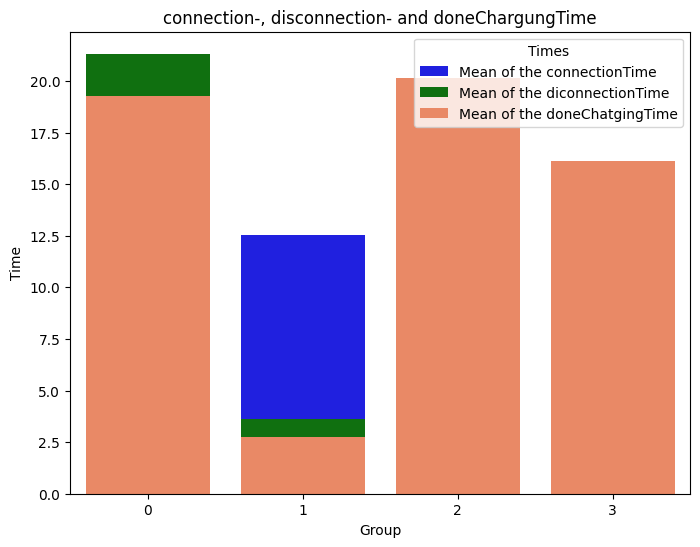

In [34]:
plt.figure(figsize=(8, 6))

sns.barplot(x=groups.index, y=groups['connectMean'], color='blue', label='Mean of the connectionTime')

sns.barplot(x=groups.index, y=groups['disconnectMean'], color='green', label='Mean of the diconnectionTime')

sns.barplot(x=groups.index, y=groups['doneChargingMean'], color='coral', label='Mean of the doneChatgingTime')

plt.title("connection-, disconnection- and doneChargungTime")
plt.xlabel("Group")
plt.ylabel("Time")
plt.legend(title='Times')

{'icoord': [[35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [15.0, 15.0, 32.5, 32.5],
  [5.0, 5.0, 23.75, 23.75],
  [65.0, 65.0, 75.0, 75.0],
  [55.0, 55.0, 70.0, 70.0],
  [14.375, 14.375, 62.5, 62.5],
  [95.0, 95.0, 105.0, 105.0],
  [85.0, 85.0, 100.0, 100.0],
  [115.0, 115.0, 125.0, 125.0],
  [145.0, 145.0, 155.0, 155.0],
  [135.0, 135.0, 150.0, 150.0],
  [120.0, 120.0, 142.5, 142.5],
  [175.0, 175.0, 185.0, 185.0],
  [165.0, 165.0, 180.0, 180.0],
  [205.0, 205.0, 215.0, 215.0],
  [195.0, 195.0, 210.0, 210.0],
  [225.0, 225.0, 235.0, 235.0],
  [245.0, 245.0, 255.0, 255.0],
  [230.0, 230.0, 250.0, 250.0],
  [202.5, 202.5, 240.0, 240.0],
  [172.5, 172.5, 221.25, 221.25],
  [131.25, 131.25, 196.875, 196.875],
  [92.5, 92.5, 164.0625, 164.0625],
  [38.4375, 38.4375, 128.28125, 128.28125],
  [295.0, 295.0, 305.0, 305.0],
  [285.0, 285.0, 300.0, 300.0],
  [275.0, 275.0, 292.5, 292.5],
  [325.0, 325.0, 335.0, 335.0],
  [315.0, 315.0, 330.0, 330.0],
  [283.75, 283.75, 322.5, 322.5],


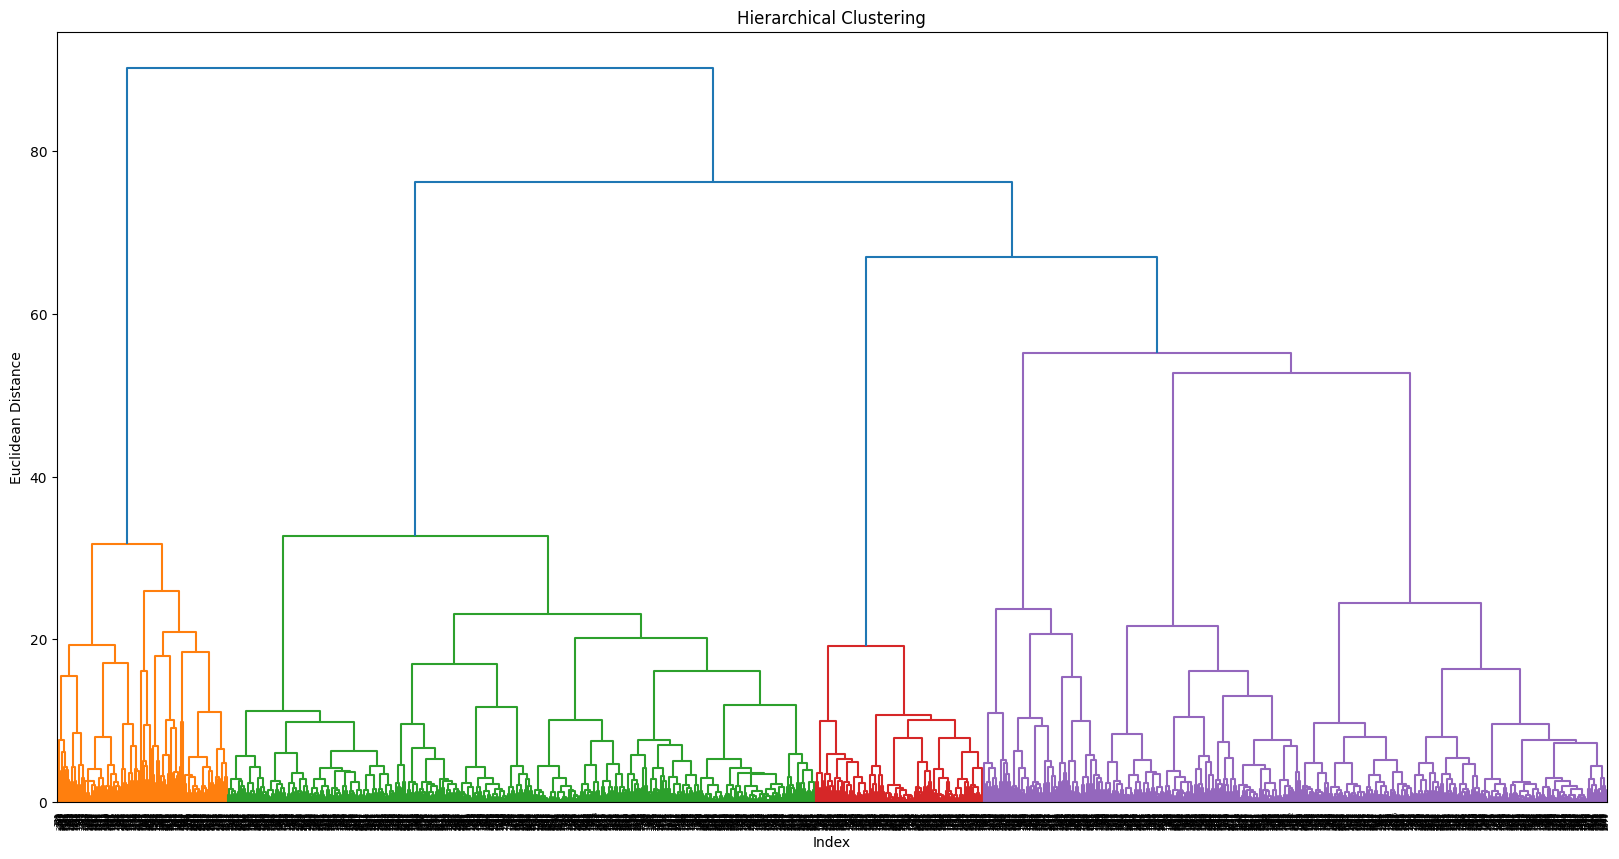

In [35]:
plt.figure(figsize=(20, 10))  
plt.title("Hierarchical Clustering")  
plt.xlabel('Index')
plt.ylabel('Euclidean Distance')
dendrogram(linkage(X_scaled_sam, method='ward', ))

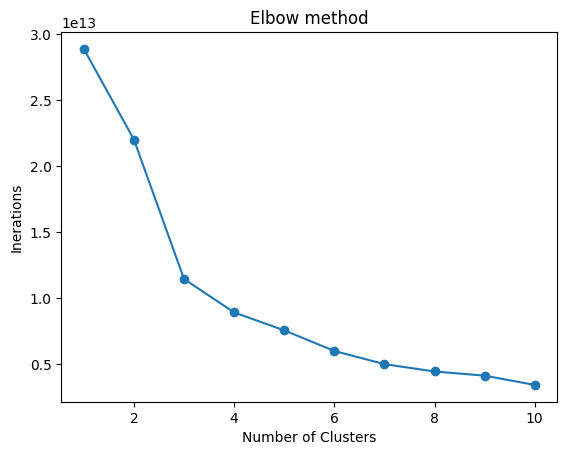

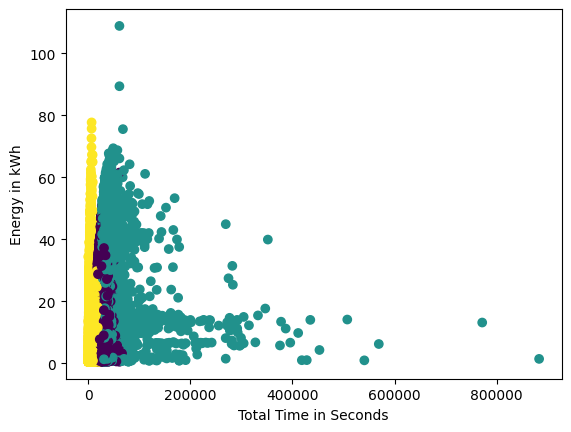

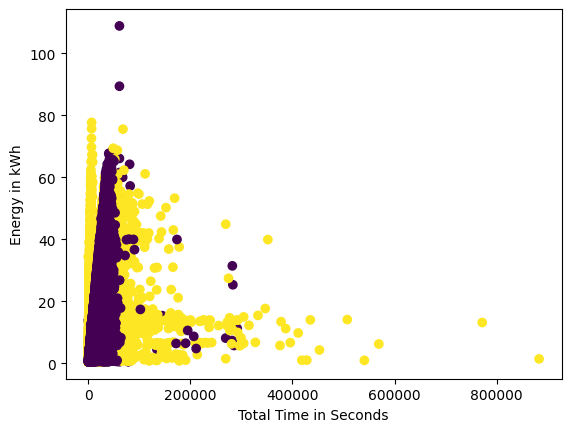

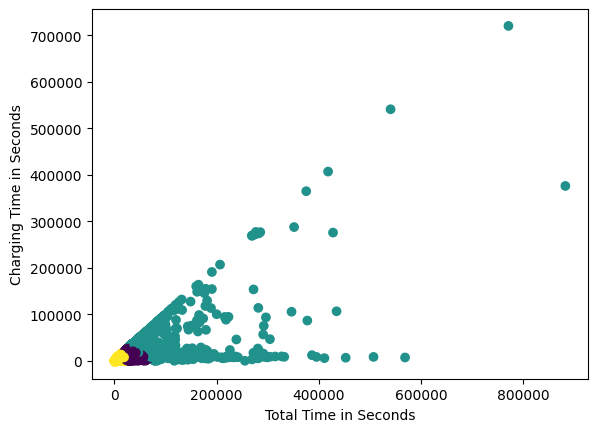

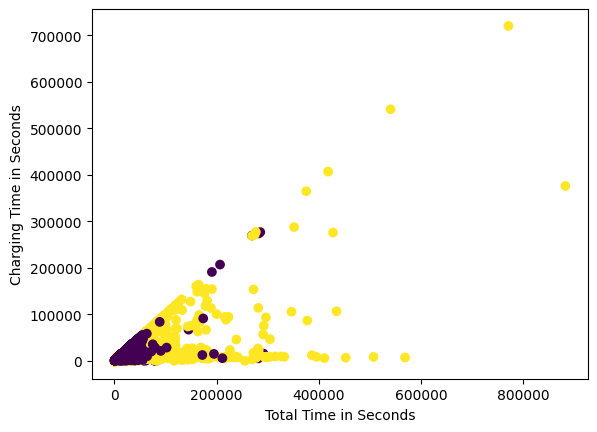

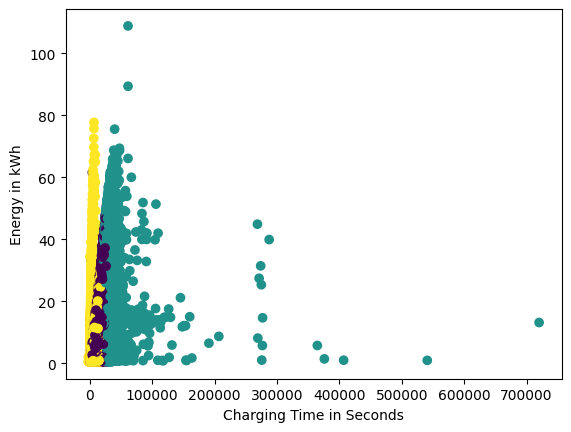

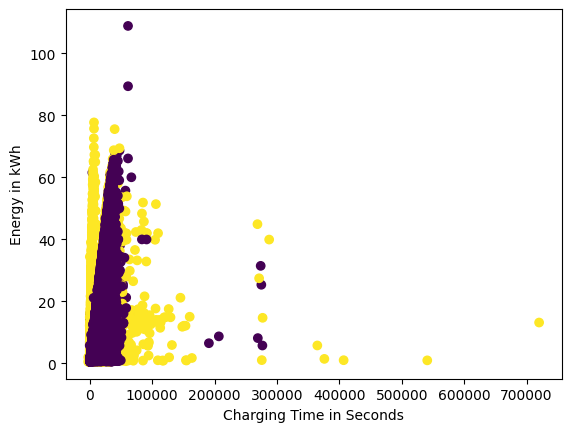

In [36]:
# Clustering using https://www.w3schools.com/python/python_ml_k-means.asp as basis
data = list(zip(time_sec, KWh, time_charging_sec))
it = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    it.append(kmeans.inertia_)

plt.plot(range(1,11), it, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inerations')
plt.show() 

kmeans = KMeans(n_clusters=3)
kmeans.fit(data)
it.append(kmeans.inertia_)

plt.scatter(x=time_sec, y=KWh, c=kmeans.labels_)
plt.xlabel("Total Time in Seconds")
plt.ylabel("Energy in kWh")
plt.show() 


plt.scatter(x=time_sec, y=KWh, c=site_Id)
plt.xlabel("Total Time in Seconds")
plt.ylabel("Energy in kWh")
plt.show() 

plt.scatter(x=time_sec, y=time_charging_sec, c=kmeans.labels_)
plt.xlabel("Total Time in Seconds")
plt.ylabel("Charging Time in Seconds")
plt.show() 


plt.scatter(x=time_sec, y=time_charging_sec, c=site_Id)
plt.xlabel("Total Time in Seconds")
plt.ylabel("Charging Time in Seconds")
plt.show() 

plt.scatter(x=time_charging_sec, y=KWh, c=kmeans.labels_)
plt.xlabel("Charging Time in Seconds")
plt.ylabel("Energy in kWh")
plt.show() 


plt.scatter(x=time_charging_sec, y=KWh, c=site_Id)
plt.xlabel("Charging Time in Seconds")
plt.ylabel("Energy in kWh")
plt.show() 

In [37]:
# Analysing the Groups of the simple k-means using centroids/averages
ana_simple = pd.DataFrame()
ana_simple["total_time"] = time_sec
ana_simple["kWh"] = KWh
ana_simple["charging_time"] = time_charging_sec
ana_simple["group"] = kmeans.labels_
ana_simple["site"] = site_Id

# averages
print(ana_simple.groupby("group").mean())

# how often time
site_1 = ana_simple[ana_simple.site == 1]
site_2 = ana_simple[ana_simple.site == 2]
print(site_1[site_1.group == 0].shape)
print(site_1[site_1.group == 1].shape)
print(site_1[site_1.group == 2].shape)
print(site_2[site_2.group == 0].shape)
print(site_2[site_2.group == 1].shape)
print(site_2[site_2.group == 2].shape)
print(site_1.shape)
print(site_2.shape)

         total_time        kWh  charging_time      site
group                                                  
0      30709.564773  11.817252   12965.910378  1.405603
1      40643.494475  22.121247   31416.657544  1.354642
2       9707.632409   8.433931    7132.310517  1.570212
(15871, 5)
(6249, 5)
(12922, 5)
(10830, 5)
(3434, 5)
(17144, 5)
(35042, 5)
(31408, 5)


In [38]:
# Clustering depending on siteID
# Site 1
data_clustering_site1_split = input_data[input_data.siteID == 1]

# getting the time based data
time_in_s1 = data_clustering_site1_split["connectionTime"]
time_in_s1 = pd.to_datetime(time_in_s1)
time_in_s1 = time_in_s1.dt.hour + time_in_s1.dt.minute / 60

time_out_s1 = data_clustering_site1_split["disconnectTime"]
time_out_s1 = pd.to_datetime(time_in_s1)
time_out_s1 = time_out_s1.dt.hour + time_out_s1.dt.minute / 60

time_w_s1 = data_clustering_site1_split["doneChargingTime"]
time_w_s1 = pd.to_datetime(time_in_s1)
time_w_s1 = time_w_s1.dt.hour + time_w_s1.dt.minute / 60

data_clustering_site1 = pd.DataFrame()
data_clustering_site1["connectionTime"] = time_in_s1
data_clustering_site1["diconnectionTime"] = time_out_s1
data_clustering_site1["doneChargingTime"] = time_w_s1
data_clustering_site1["kWhDelivered"] = data_clustering_site1_split["kWhDelivered"]
data_clustering_site1["minutesAvailable"] = data_clustering_site1_split["userInputs_minutesAvailable"]
data_clustering_site1["milesRequested"] = data_clustering_site1_split["userInputs_milesRequested"]
data_clustering_site1["kWhRequested"] = data_clustering_site1_split["userInputs_kWhRequested"]

# Site 2
data_clustering_site2_split = input_data[input_data.siteID == 2]

# getting the time based data
time_in_s2 = data_clustering_site2_split["connectionTime"]
time_in_s2 = pd.to_datetime(time_in_s2)
time_in_s2 = time_in_s2.dt.hour + time_in_s2.dt.minute / 60

time_out_s2 = data_clustering_site2_split["disconnectTime"]
time_out_s2 = pd.to_datetime(time_in_s2)
time_out_s2 = time_out_s2.dt.hour + time_out_s2.dt.minute / 60

time_w_s2 = data_clustering_site2_split["doneChargingTime"]
time_w_s2 = pd.to_datetime(time_in_s2)
time_w_s2 = time_w_s2.dt.hour + time_w_s2.dt.minute / 60

data_clustering_site2 = pd.DataFrame()
data_clustering_site2["connectionTime"] = time_in_s2
data_clustering_site2["diconnectionTime"] = time_out_s2
data_clustering_site2["doneChargingTime"] = time_w_s2
data_clustering_site2["kWhDelivered"] = data_clustering_site2_split["kWhDelivered"]
data_clustering_site2["minutesAvailable"] = data_clustering_site2_split["userInputs_minutesAvailable"]
data_clustering_site2["milesRequested"] = data_clustering_site2_split["userInputs_milesRequested"]
data_clustering_site2["kWhRequested"] = data_clustering_site2_split["userInputs_kWhRequested"]

In [39]:
# Sampling the data
data_sampled_s1 = data_clustering_site1.sample(n=3000, random_state=42)

In [40]:
# scaling the data, not sure if i need that
  
X_sampled_s1 = data_sampled_s1

scaler = StandardScaler()
scaler.fit(data_sampled_s1)
X_scaled_sam_s1 = scaler.transform(X_sampled_s1)
X_scaled_sam_s1_df = pd.DataFrame(X_scaled_sam_s1, columns=data_sampled_s1.columns, index=data_sampled_s1.index)
X_scaled_sam_s1_df.head()

data_clustering_sam_s1 = X_scaled_sam_s1_df

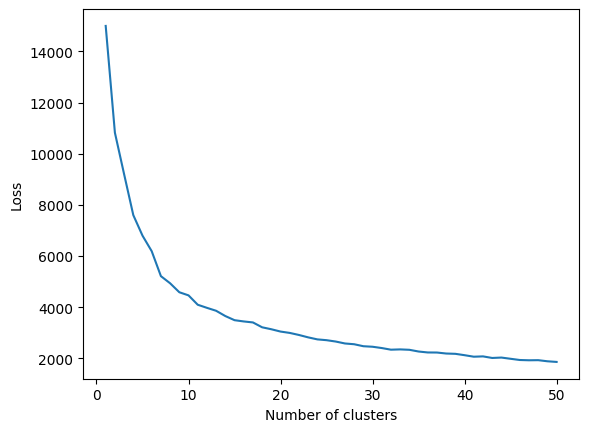

In [41]:
k_max = 50

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters=k+1, n_init='auto')
    model.fit(X_scaled_sam_s1)
    clusters.append(k+1)
    losses.append(model.inertia_)


plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

(0.0, 10.0)

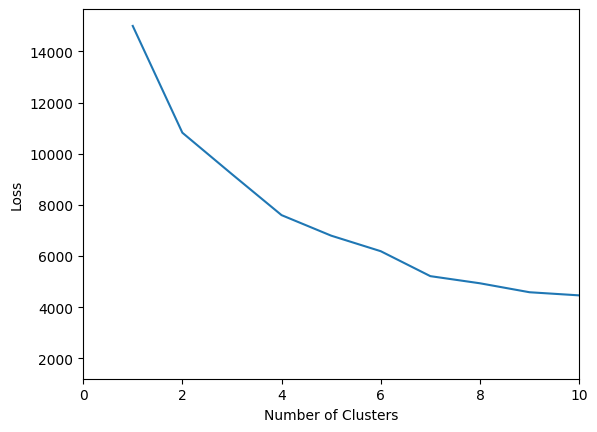

In [42]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of Clusters")
plt.xlim([0,10])

In [43]:
# refit algorithm
two_means_sam_s1 = KMeans(n_clusters=4, n_init='auto')
two_means_sam_s1.fit(X_scaled_sam_s1)

# match records to clusters by calling predict
two_means_sam_s1.predict(X_scaled_sam_s1)

array([3, 0, 2, ..., 2, 2, 3])

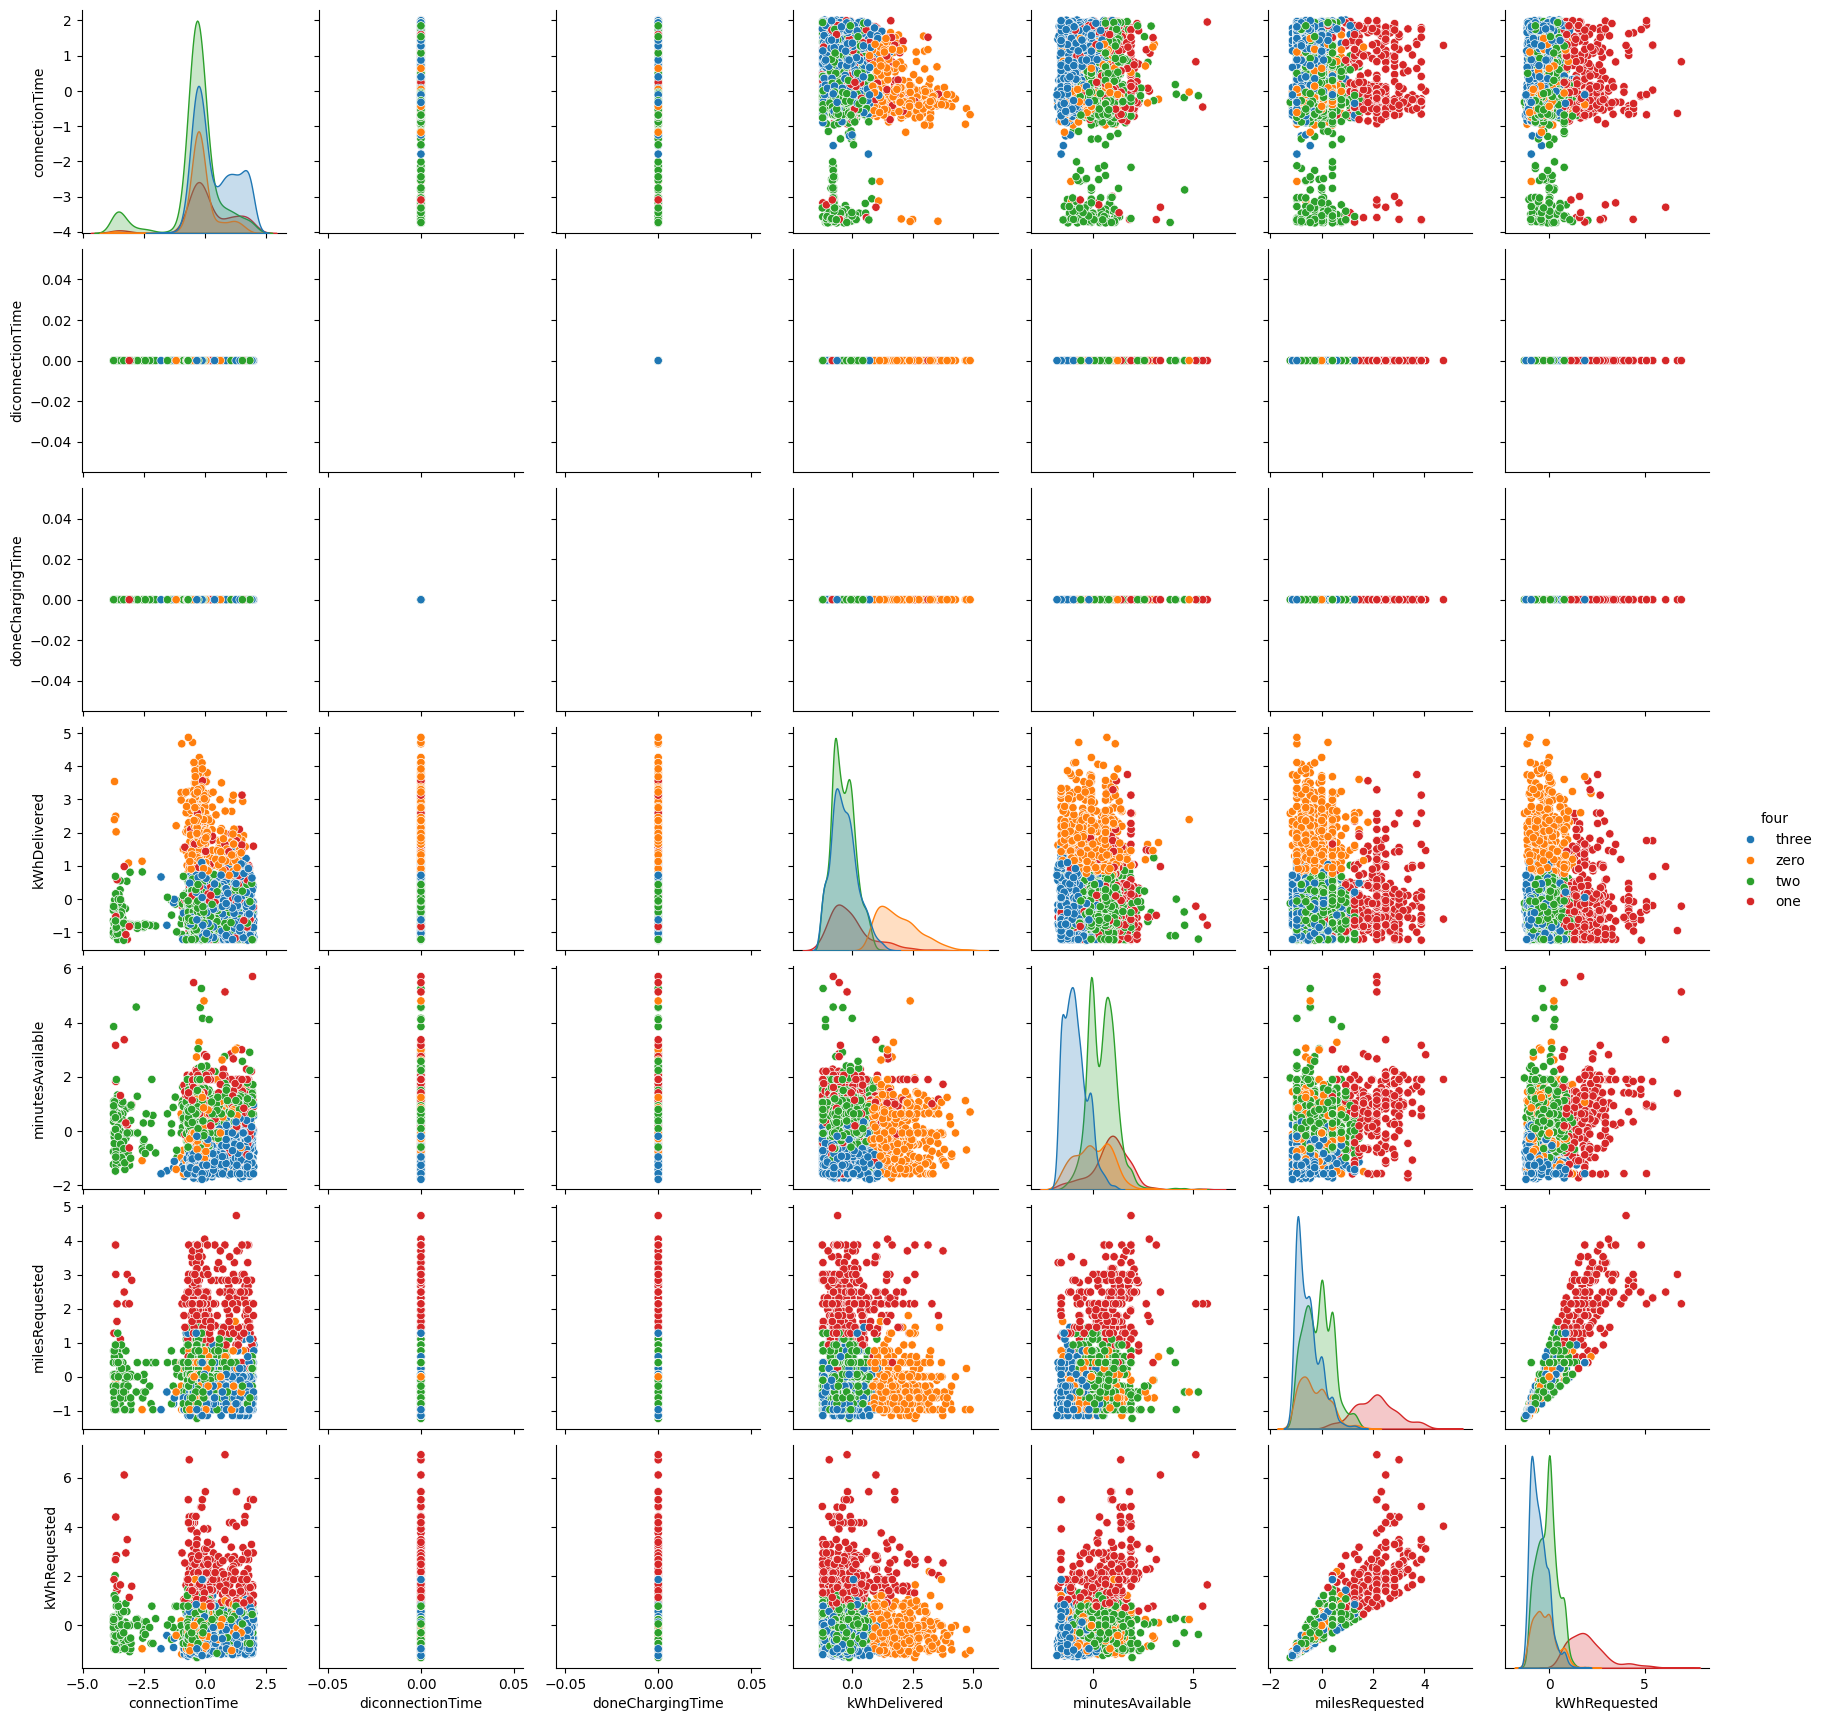

In [44]:
numbers = ["zero", "one", "two", "three", "four"] 

data_clustering_sam_s1["four"] = two_means_sam_s1.predict(X_scaled_sam_s1)
data_clustering_sam_s1["four"] = data_clustering_sam_s1["four"].apply(lambda x: numbers[x])
pair_plot = sns.pairplot(data=data_clustering_sam_s1, hue="four")

In [45]:
# Sampling the data
data_sampled_s2 = data_clustering_site2.sample(n=3000, random_state=42)

In [46]:
# scaling the data
  
X_sampled_s2 = data_sampled_s2

scaler = StandardScaler()
scaler.fit(data_sampled_s2)
X_scaled_sam_s2 = scaler.transform(X_sampled_s2)
X_scaled_sam_s2_df = pd.DataFrame(X_scaled_sam_s2, columns=data_sampled_s2.columns, index=data_sampled_s2.index)
X_scaled_sam_s2_df.head()

data_clustering_sam_s2 = X_scaled_sam_s2_df

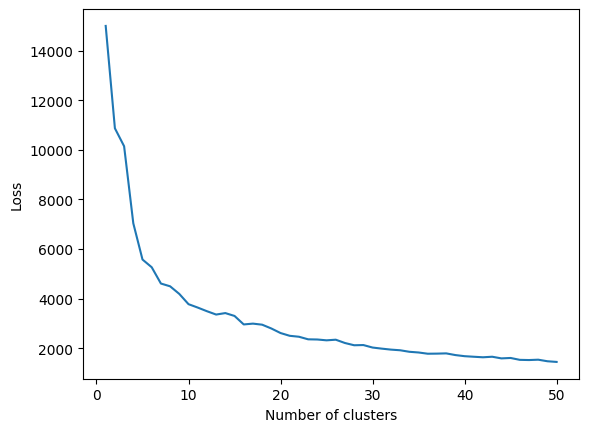

In [47]:
k_max = 50

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters=k+1, n_init='auto')
    model.fit(X_scaled_sam_s2)
    clusters.append(k+1)
    losses.append(model.inertia_)


plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

(0.0, 10.0)

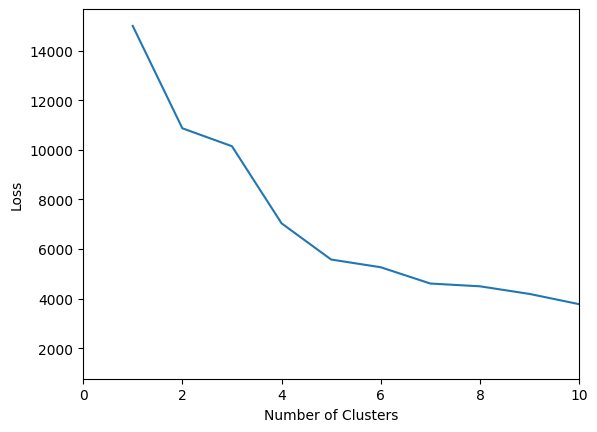

In [48]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of Clusters")
plt.xlim([0,10])

In [49]:
# refit algorithm
two_means_sam_s2 = KMeans(n_clusters=4, n_init='auto')
two_means_sam_s2.fit(X_scaled_sam_s2)

# match records to clusters by calling predict
two_means_sam_s2.predict(X_scaled_sam_s2)

array([1, 1, 1, ..., 1, 3, 1])

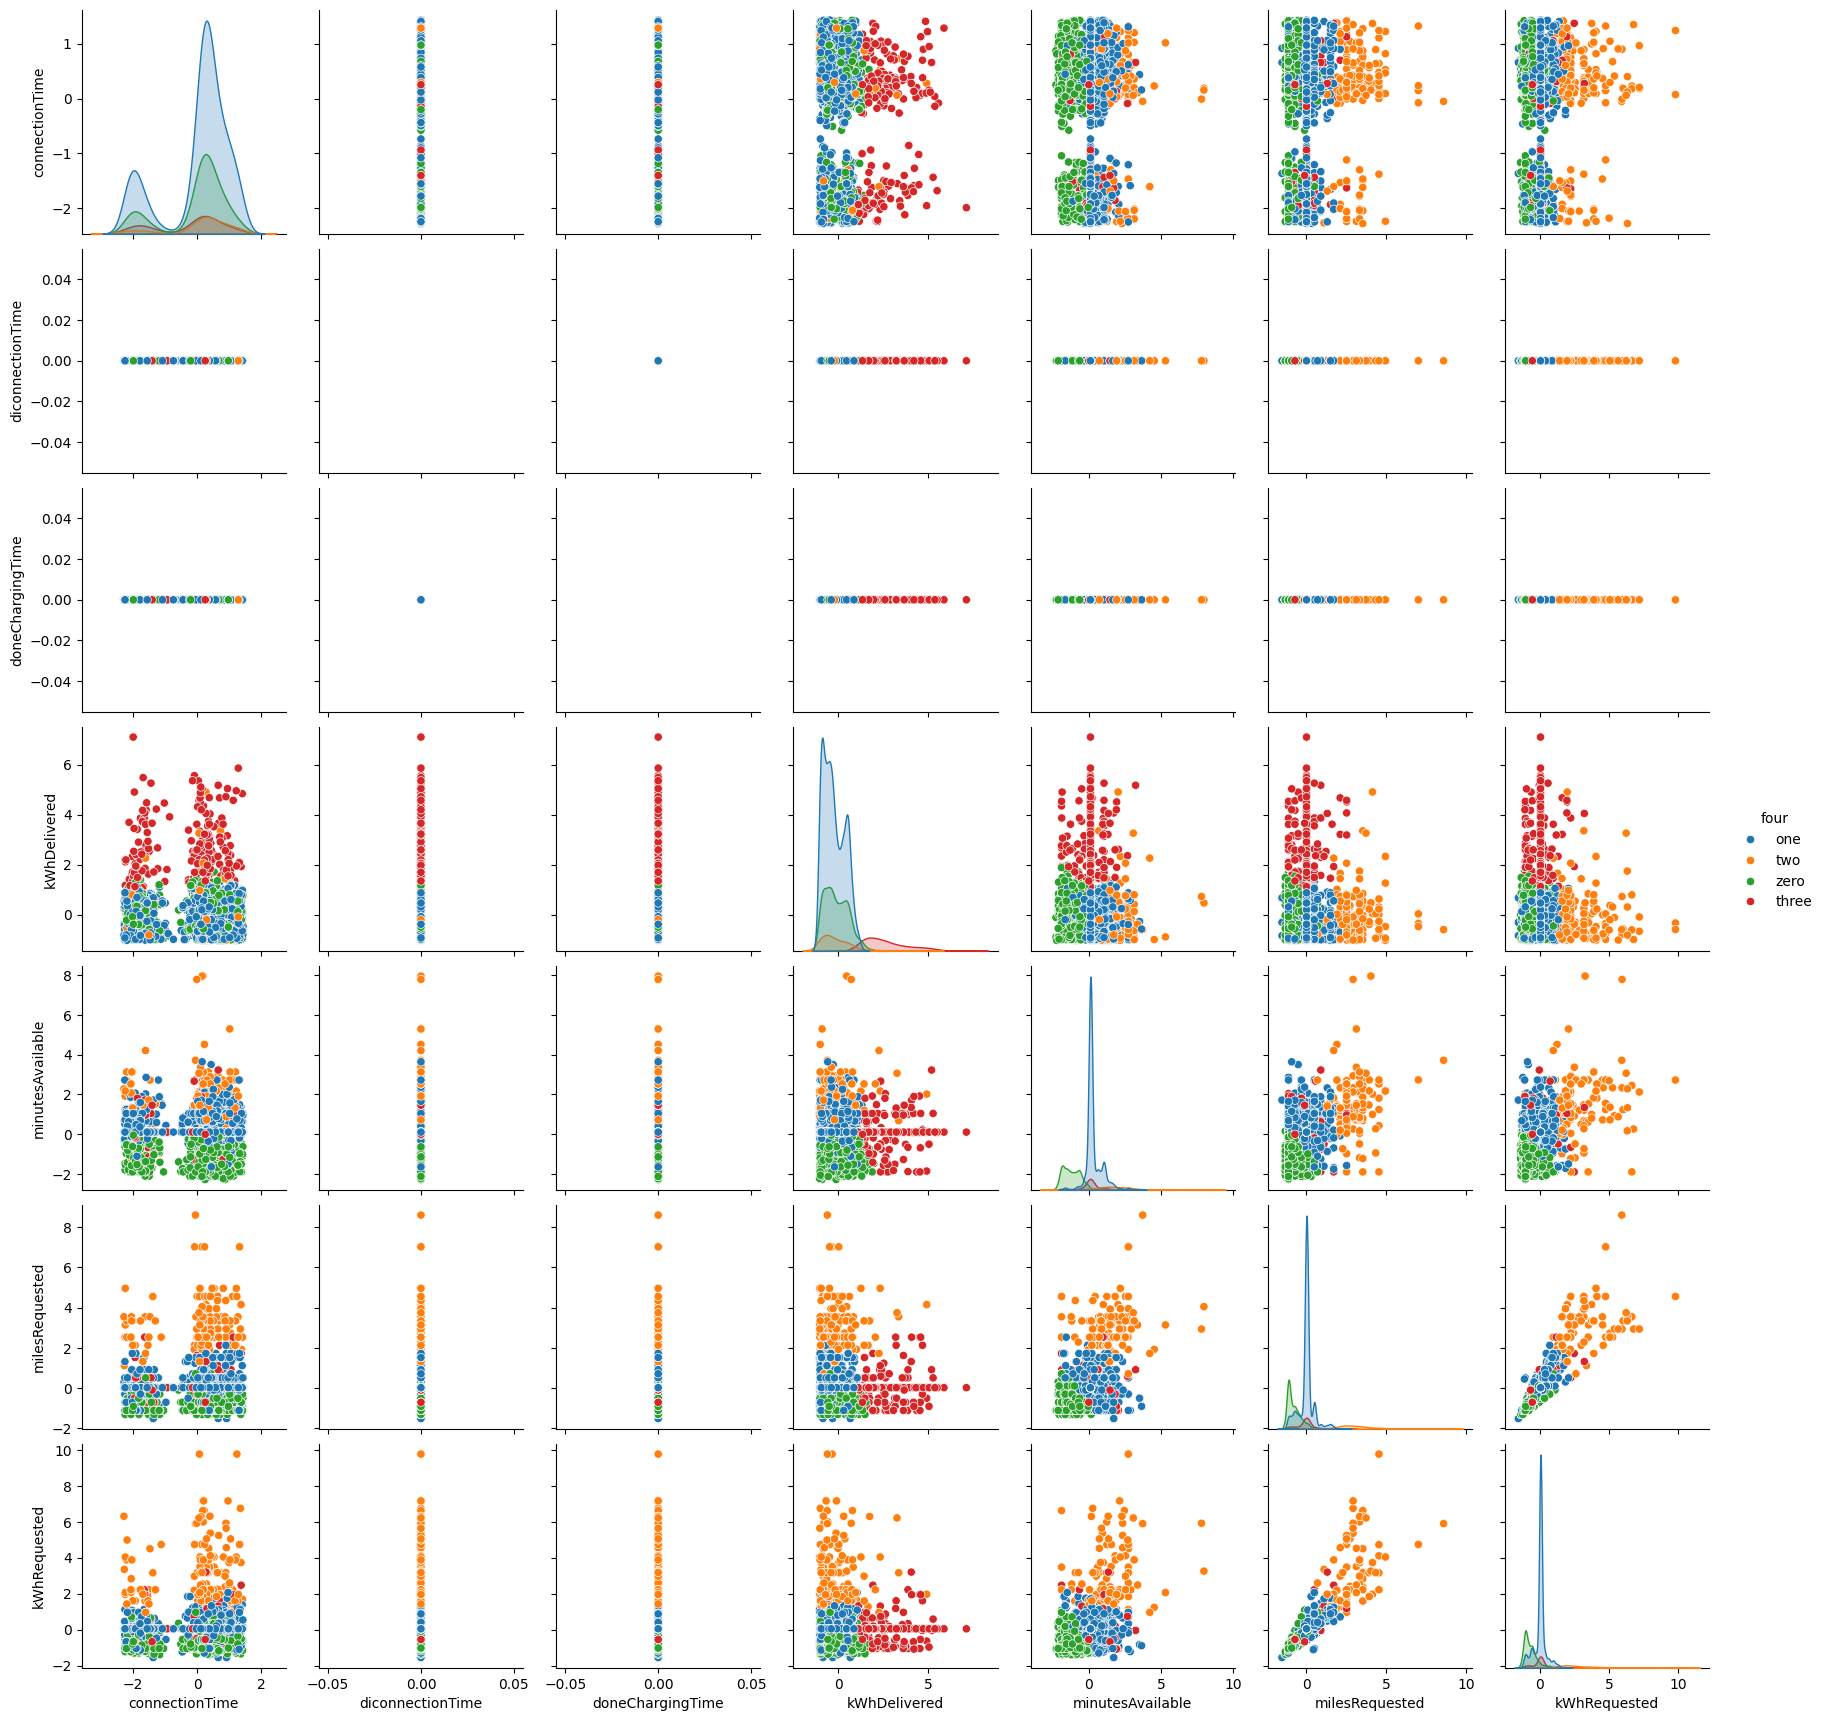

In [50]:
numbers = ["zero", "one", "two", "three", "four"] 

data_clustering_sam_s2["four"] = two_means_sam_s2.predict(X_scaled_sam_s2)
data_clustering_sam_s2["four"] = data_clustering_sam_s2["four"].apply(lambda x: numbers[x])
pair_plot = sns.pairplot(data=data_clustering_sam_s2, hue="four")